In [18]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [19]:
words = open('names.txt', 'r').read().splitlines()

chars = sorted(list(set(''.join(words))))
i2s = {p+1:l for p, l in enumerate(chars)}
i2s[0] = '.'

s2i = {}

for i, l in i2s.items():
    s2i[l] = i
    
vocab_size = len(s2i)

In [31]:
block_size = 3

def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = s2i[ch] 
            Y.append(ix)
            X.append(context)
            context = context[1:] + [ix]
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)

n1 = int(.8*len(words))
n2 = int(.9*len(words))

Xtr, Ytr = build_dataset(words[:n1]) # train_words
Xdev, Ydev = build_dataset(words[n1:n2]) # dev_words
Xte, Yte = build_dataset(words[n2:]) # test_words



In [96]:
class Linear:  # TRANSFORMATION LAYER
  
  def __init__(self, fan_in, fan_out, bias=True):  # FAN IN IS AMOUNT OF INPUTS, FAN OUT AMOUNT OF OUTPUTS
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5  # CREATES TENSOR OF INPUT x OUTPUT SIZE with normal distrib
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
     def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

  
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
    return [self.gamma, self.beta]

  

class Tanh:
     def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
     def parameters(self):
        return []

class Embedding:  # THIS CREATES A EMBEDDING MATRIX TO SAMPLE INTO (27 Letters x 10 dims)
    
    def __init__(self, num_embeddings, emb_dims):
        self.weight = torch.randn((num_embeddings, emb_dims))
        
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    def parameters(self):
        return [self.weight]
    
class Flatten:
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out
    def parameters(self):
        return []
    
class Sequential:
    def __init__(self, layers):
        self.layers = layers
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters() ]
    

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

# C = torch.randn((vocab_size, n_embd),            generator=g)  REMOVED THIS WITH CLASS: EMBEDDING

              
              # THIS WAS THE PREVIOUS WAY TO DO THIS, Sequential class fixes this
# layers = [  # THIS IS CREATING A LIST WHERE EACH TRANSFORM WILL HAPPEN::: EMB => Flat => WEIGHTS => BATCHNORM => TanH
#   Embedding(vocab_size, n_embd), Flatten(),
#   Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
# ]

model = Sequential([  # CREATES A SEQUENTIAL CLASS NAMED model which is used in forward pass
  Embedding(vocab_size, n_embd),      Flatten()    , BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
])


# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
    layers[-1].gamma *= 0.1
#   layers[-1].weight *= 0.1
  # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1.0 #5/3

         
params = 0
parameters = model.parameters()
for p in parameters:
    p.requires_grad = True
    params += 1

print(f"there are {params} parameters in total") # number of parameters in total


AttributeError: 'BatchNorm1d' object has no attribute 'parameters'

In [88]:
# same optimization as last time
max_steps = 5000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    
      
  # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g) # CREATES RAND INTS OF "BATCH SIZE" FROM 0 => Training size
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  #   forward pass          SIMPLIFIED BY ADDING EMBED AND FLATTEN CLASSES
#     emb = C[Xb] # embed the characters into vectors
#     print(emb.shape)
#     x = emb.view(emb.shape[0], -1) # concatenate the vectors
#     x = Xb
#     for layer in layers:  # LOOP THE LAYERS AND PERFORM TRANSFORM
    
    logits = model(Xb) # CALLING THE SEQUENTIAL CLASS MADE EARLIER
    loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
  
  # update
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

  # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    if i >= 1000:
        if i % 1000 == 0:
            print("training network ...")
#         print("Test Stage - Remove Break")
#         break # AFTER_DEBUG: would take out obviously to run full optimization

print("finished")

      0/   5000: 3.0709
training network ...
training network ...
training network ...
training network ...
finished


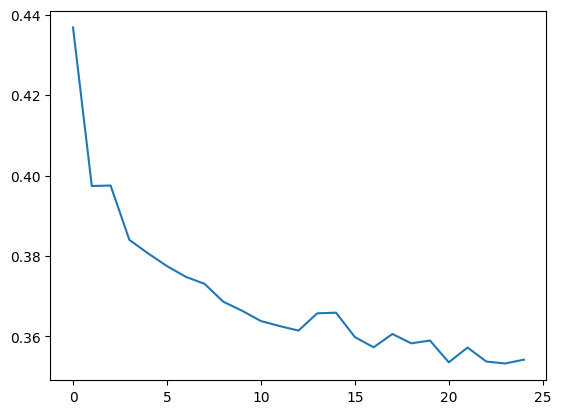

In [89]:
for layer in model.layers():
    layer.training = False

lossi_tensor = torch.tensor(lossi)
plt.plot(lossi_tensor.view(-1, 200).mean(1, keepdim=True))


In [90]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)
block_size = 3

for _ in range(30):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
#         emb = C[torch.tensor([context])] # (1,block_size,n_embd)
#         x = emb.view(emb.shape[0], -1) # concatenate the vectors
        
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
      # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
      # if we sample the special '.' token, break
        if ix == 0:
            break
    
    print(''.join(i2s[i] for i in out)) # decode and print the generated word

mora.
mayah.
seel.
ndhayla.
rethaniendra.
kalderydoeliah.
miloelle.
eliesonnarlelleioh.
karin.
shibergia.
miel.
kin.
rendlionnthana.
ubrighdir.
yah.
fyeha.
kayshistonah.
hil.
sakyansyn.
zakrie.
mari.
cre.
kiviaosien.
adbinen.
merih.
gpeila.
karey.
hah.
rayleid.
siri.
